# Time series data preprocessing
Most of the time datasets cannot be used directly to train a model. They might come with missing records or values, or we might need to change the format of one or more fields. For example time can be provided as string and we need numerical value. In this notebook we apply several transformations to the [Individual Household Electric Power Consumption](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption) dataset that are quite common when dealing with data preparation for machine learning. The dataset contains a series of measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years, from 16 Dec. 2006 to 26 Nov. 2010.

In [20]:
import requests
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
print("NumPy version: %s"%np.__version__)
print('Pandas version: %s'%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.8.4


In [8]:
data_url = 'https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip'

In [9]:
r = requests.get(data_url)

In [10]:
file_path = f'data/individual_household_electric_power+consumption.zip'
with open(file_path, 'wb') as f:
        f.write(r.content)

In [11]:
f.close()

In [12]:
DATADIR = './data'

In [13]:
with ZipFile(f'{DATADIR}/individual_household_electric_power_consumption.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/')

We open the dataset as a Pandas DataFrame

In [19]:
household_power_consumption_df = pd.read_table('data/household_power_consumption.txt', sep=';', low_memory=False)
household_power_consumption_df.shape

(2075259, 9)

In [18]:
household_power_consumption_df.head(1)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0


In [22]:
household_power_consumption_df.tail(1)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075258,26/11/2010,21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.0


### Dealing with missing data
We look for missing, that is $null$, values. Only one column contain null values. 

In [27]:
is_na_df = household_power_consumption_df.isna()
is_na_df.sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

We calculate the length of the longest set of consecuitive minutes of missing values

In [28]:
na_groups = household_power_consumption_df['Sub_metering_3'].notna().cumsum()[is_na_df['Sub_metering_3']]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)
longest_na_gap = len_consecutive_na.max()
longest_na_gap

7226

It means there are 5 consecutive days without data

In [30]:
longest_na_gap / (60 * 24)

5.018055555555556

Since the number of consecutive records without observations for this column is large to be interpolated we remove the column 

In [31]:
household_power_consumption_df = household_power_consumption_df.drop(['Sub_metering_3'], axis=1)
household_power_consumption_df.shape

(2075259, 8)

### Data type conversion
We can see that the columns data type is string. 

In [44]:
def print_col_data_type(df):
    for column in df.columns:
        column_data_type = type(df[column].iloc[0])
        print(column_data_type)

In [45]:
print_col_data_type(household_power_consumption_df)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


We change the data type, from string to float64, of all but the first two columns that contain the date and the time of each observation.

In [50]:
cols_to_convert = household_power_consumption_df.columns[2:]
household_power_consumption_df[cols_to_convert] = household_power_consumption_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [51]:
print_col_data_type(household_power_consumption_df)

<class 'str'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [52]:
household_power_consumption_df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

### Data resampling
We can resample the data to reduce the noise. 

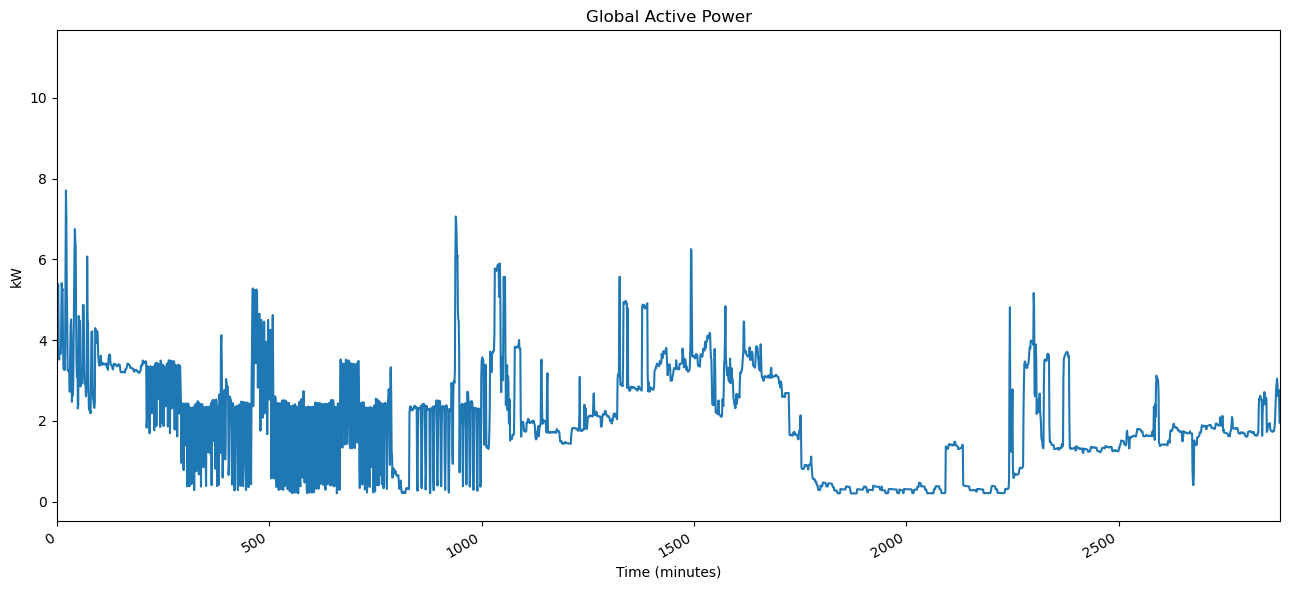

In [60]:
fig, ax = plt.subplots(figsize=(13,6))
fig.autofmt_xdate()
ax.set_title('Global Active Power')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('kW')
ax.set_xlim(0, 60 * 24 * 2) # two days plot
ax.plot(household_power_consumption_df['Global_active_power'])
plt.tight_layout()

One other reason to resample is that we might not be interested in training a model to forecast the power consumption by the minute, one hour may be enough so we resample the data by hours.

In [70]:
household_power_consumption_datetime = household_power_consumption_df.Date + ' ' + household_power_consumption_df.Time
household_power_consumption_datetime

0          16/12/2006 17:24:00
1          16/12/2006 17:25:00
2          16/12/2006 17:26:00
3          16/12/2006 17:27:00
4          16/12/2006 17:28:00
                  ...         
2075254    26/11/2010 20:58:00
2075255    26/11/2010 20:59:00
2075256    26/11/2010 21:00:00
2075257    26/11/2010 21:01:00
2075258    26/11/2010 21:02:00
Length: 2075259, dtype: object

In [73]:
datetime_index = pd.to_datetime(household_power_consumption_datetime, format='%d/%m/%Y %H:%M:%S')

In [74]:
household_power_consumption_df.loc[:,'datetime'] = datetime_index

In [75]:
household_power_consumption_df = household_power_consumption_df.drop(['Date', 'Time'], axis=1)
household_power_consumption_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,2006-12-16 17:28:00


In [78]:
hourly_household_power_consumption_df = household_power_consumption_df.resample('h', on='datetime').sum()
hourly_household_power_consumption_df.head(1)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0


We remove the first and last record of the hourly data since they do not have the full 60 minutes of data

In [80]:
hourly_household_power_consumption_df = hourly_household_power_consumption_df.drop(hourly_household_power_consumption_df.tail(1).index)
hourly_household_power_consumption_df = hourly_household_power_consumption_df.drop(hourly_household_power_consumption_df.head(1).index)

We reset the index to integers to keep the datatime as a variable

In [81]:
hourly_household_power_consumption_df = hourly_household_power_consumption_df.reset_index()
hourly_household_power_consumption_df.head(1)

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0


In [82]:
hourly_household_power_consumption_df.shape

(34587, 7)

In [83]:
days = ['2006-12-17', 
        '2006-12-18', 
        '2006-12-19', 
        '2006-12-20', 
        '2006-12-21', 
        '2006-12-22', 
        '2006-12-23', 
        '2006-12-24', 
        '2006-12-25', 
        '2006-12-26', 
        '2006-12-27', 
        '2006-12-28', 
        '2006-12-29', 
        '2006-12-30', 
        '2006-12-31']

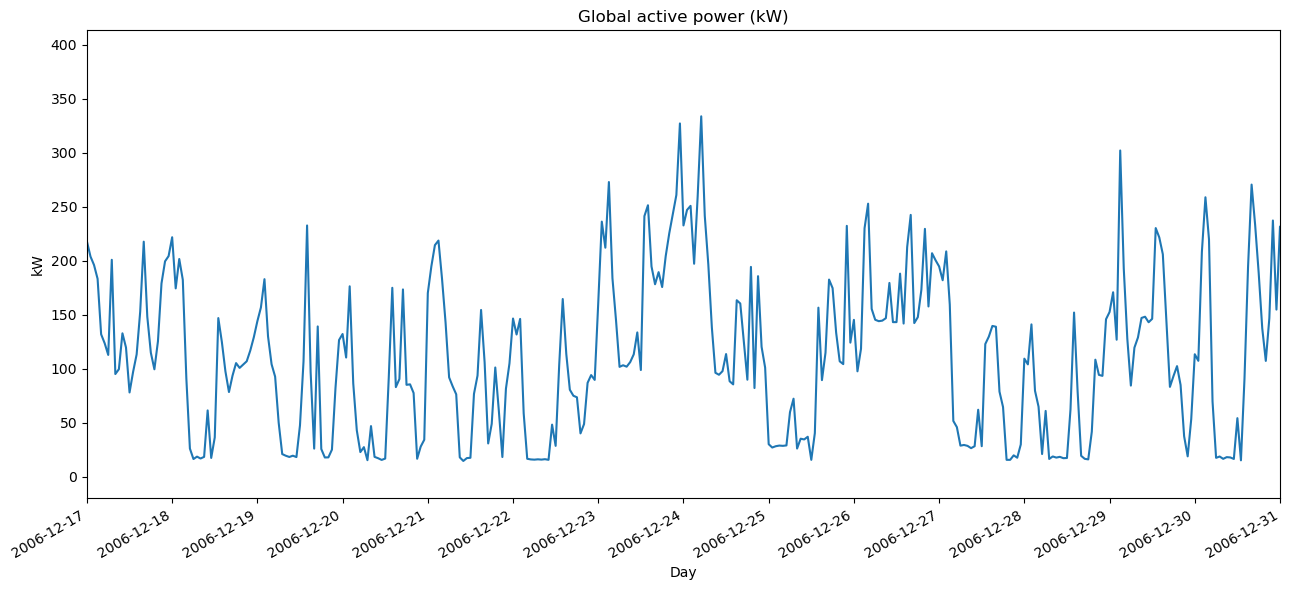

In [86]:
fig, ax = plt.subplots(figsize=(13,6))
fig.autofmt_xdate()
ax.set_xlabel('Day')
ax.set_ylabel('kW')
ax.set_title('Global active power (kW)')
ax.set_xlim(0, 336)
ax.plot(hourly_household_power_consumption_df['Global_active_power'])
plt.xticks(np.arange(0, 360, 24), days)
plt.tight_layout()

In [87]:
hourly_household_power_consumption_df.to_csv('data/household_power_consumption.csv', header=True, index=False)